# Image Reduction using PCA
In this project, we explore the application of Principal Component Analysis (PCA) in the domain of image processing.

**Why PCA?**

Dimensionality Reduction: Images are often represented by high-dimensional feature vectors, making them computationally expensive to analyze and store. PCA helps reduce the dimensionality of these vectors while retaining essential information, enabling more efficient processing.

Noise Reduction: By focusing on the principal components that capture the most variance in the data, PCA can effectively filter out noise and irrelevant information from images, leading to cleaner and more interpretable results.

Visualization: PCA facilitates visualization of high-dimensional image data by projecting it onto a lower-dimensional subspace. This allows for easier interpretation and understanding of image patterns and structures.

**Project Objective:
In this project, we aim to apply PCA to reduce the dimensionality of image data and capture similarity between cars while preserving key features and structures.**
<img src="https://media.licdn.com/dms/image/D4D12AQF61SUXClGqIg/article-cover_image-shrink_720_1280/0/1660108512262?e=1716422400&v=beta&t=10Fo2-oZJdVd9MRY1P_HeT8aymBAlTsKxbu8F38iwvg" alt="Image Title" width="500" height="200">


# Libraries

In [1]:
import os
import random
import cv2
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.sparse.linalg as ssl
import aux_funcs #py file contain some functions
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importing random images
random.seed(8)
imgs = random.sample(os.listdir("../data/cars_images"),k=200)
print(f'Total Number Of Images : {len(imgs)}')
#Converting each image to marix that represent this image
try:
    imgs = [cv2.cvtColor(imread("cars_images/"+img), cv2.COLOR_BGR2GRAY) for img in imgs]
    print('Conversion Completed')
except Exception as e:
    print(e)

Total Number Of Images : 200
Conversion Completed


We have 200 image with (100, 100) Pixel each


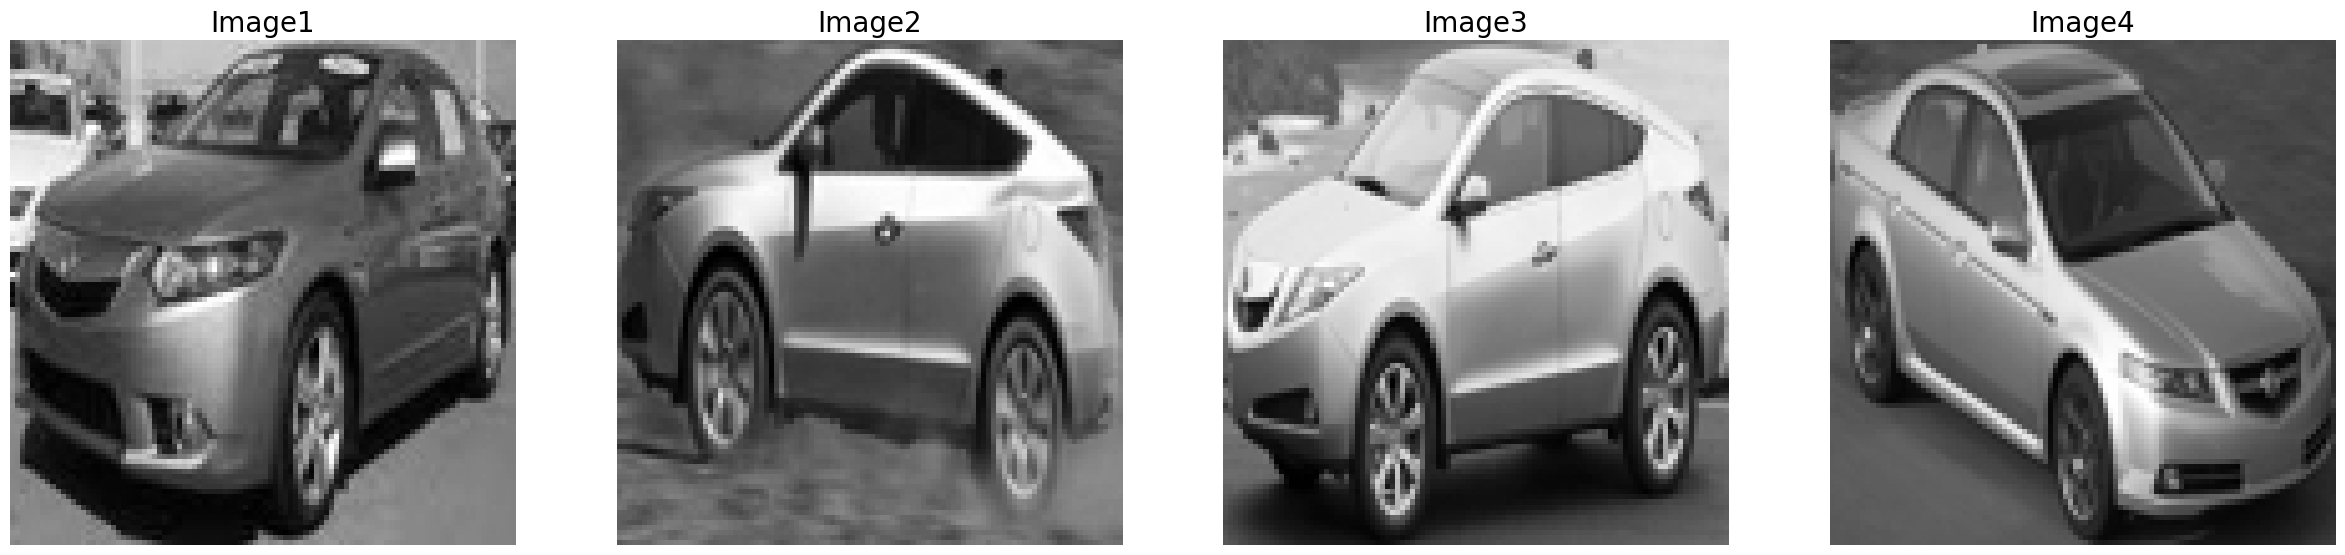

In [3]:
_,ax = plt.subplots(1,4, figsize=(30,30))
for n in range(4):
    ax[n].imshow(imgs[n],cmap='grey')
    ax[n].set_title(f'Image{n+1}',size=20)
    ax[n].axis('off')
print(f'We have {len(imgs)} image with {imgs[5].shape} Pixel each')

In [4]:
#The resulting array will have 200 rows, one for each image, and 100x100=10000 columns.
imgs_flatten = np.array([im.reshape(-1) for im in imgs])
print('Flatten Shape:',imgs_flatten.shape)

Flatten Shape: (200, 10000)


# We will achieve the goal from the data with two different approches just to clarify that the concept is the same!
----

##  1 : Applying PCA algorithm manually

**Get the covariance matrix**

$$\mathrm{imgs\_flatten} = \begin{bmatrix} x_{1,1} & x_{1,2} & \ldots & x_{1,4096}\\
                                           x_{2,1} & x_{2,2} & \ldots & x_{2,4096} \\
                                           \vdots & \vdots & \ddots & \vdots \\
                                           x_{55,1} & x_{55,2} & \ldots & x_{55,4096}\end{bmatrix}$$



$$\Sigma = \begin{bmatrix}Var(X_1) & Cov(X_1, X_2) & \ldots & Cov(X_1, X_{4096}) \\
                          Cov(X_1, X_2) & Var(X_2) & \ldots & Cov(X_2, X_{4096})\\
                          \vdots & \vdots & \ddots & \vdots \\
                          Cov(X_1,X_{4096}) & Cov(X_2, X_{4096}) &\ldots & Var(X_{4096})\end{bmatrix}$$



In order to get the covariance matrix you first need to center the data by subtracting the mean for each variable (column). 

$$X = \begin{bmatrix} (x_{1,1}- \mu_1) & (x_{1,2}- \mu_2) & \ldots & (x_{1,4096}- \mu_{4096})\\
                                           (x_{2,1}- \mu_1) & (x_{2,2}- \mu_2) & \ldots & (x_{2,4096}- \mu_{4096}) \\
                                           \vdots & \vdots & \ddots & \vdots \\
                                           (x_{55,1}- \mu_1) & (x_{55,2}- \mu_2) & \ldots & (x_{55,4096}- \mu_{4096})\end{bmatrix}$$


To perfrom the centering you will need three numpy functions. Click on their names if you want to read the official documentation for each in more detail:
- [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html): use this function to compute the mean of each variable, just remember to pass the correct `axis` argument.
- [`np.repeat`](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy-repeat): This will allow for you to repeat the values of each $\mu_i$ . 
- [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape): Use this function to reshape the repeated values into a matrix of shape the same size as your input data. To get the correct matrix after the reshape, remember to use the parameter `order='F'`.

In [5]:
imgs_flatten_centered = aux_funcs.center_data(data_to_center=imgs_flatten)

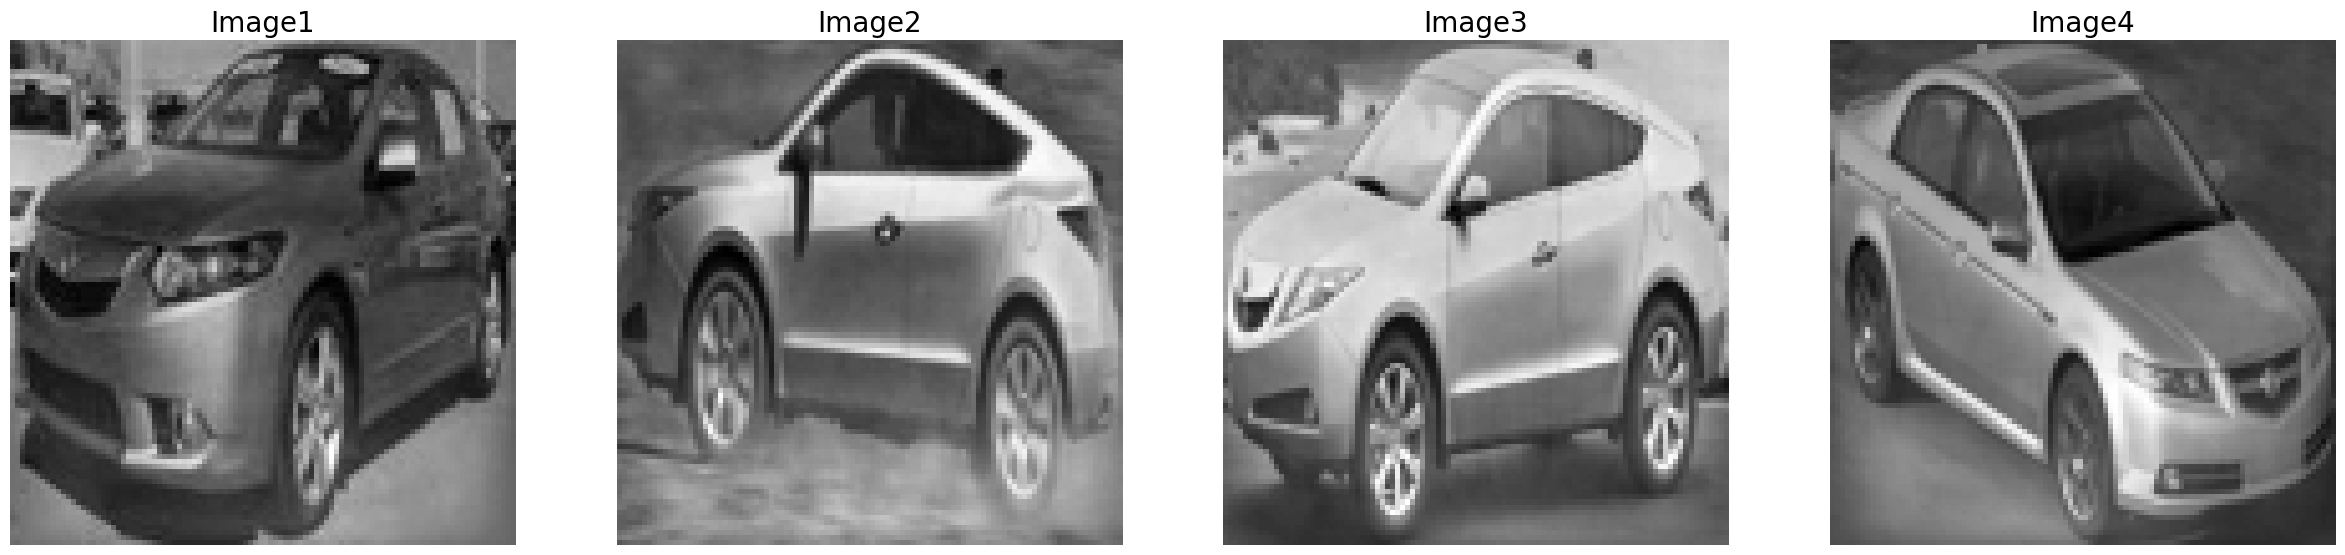

In [6]:
#The cars still look the same. This is because the color scale is not fixed, but rather relative to the values of the pixels.
fig,ax = plt.subplots(1,4, figsize=(30,30))
for n in range(4):
    ax[n].imshow(imgs_flatten_centered[n].reshape(100,100),cmap='grey')
    ax[n].set_title(f'Image{n+1}',size=20)
    ax[n].axis('off')

The covariance matrix can be found by applying the dot product between imgs_flatten_centered.T and imgs_flatten_centered,and divide by the number of observations minus 1.<br>
The output will be a covariance matrix with shape 10000X10000 

In [7]:
cov_matrix = aux_funcs.get_cov_matrix(data_centered=imgs_flatten_centered)
print(f'Covariance Matrix Shape {cov_matrix.shape}')

Covariance Matrix Shape (10000, 10000)


Compute eigenvalues and eigenvectors : we need to capture more variances in the data so we will consider the 200 eigenvalues and thier corresponding eigenvectors and see later how many of the eigenvectors (principal components) needed to retrieve information depending on the percentage that we choose! we will see that later on. Note that all eigenvalues after 200 will simply be zero since our matrix has 200 rows with 1 image each with dimension (200,10000).
In order to get a consistent result we will invert the order of `eigenvals` and `eigenvecs`, so they are both ordered from largest to smallest eigenvalue.

In [8]:
eigenvals, eigenvects = ssl.eigsh(cov_matrix,k=200)
eigenvals = eigenvals[::-1]
eigenvects = eigenvects[:,::-1]
print(f'Eigenvalues: {len(eigenvals)}, Eigenvectors matrix: {eigenvects.shape}')

Eigenvalues: 200, Eigenvectors matrix: (10000, 200)


- Each of the eigenvectors represent one principal components. The eigenvector associated with the largest eigenvalue will be the first principal component, the eigenvector associated with the second largest eigenvalue will be the second principal component, and so on.<br>
- We have a 200 eigenvalue and 200 eigenvector (Principal component), For each principal component it has 10000 value that
extracts some relevant patterns from each image
So, now we will perform a `200X10000 10000X2` matrix multiplication which gives us a new matrix with reduced dimensions `200X2`

In [9]:
#function:
# def perform_PCA(data_centered, eigenvects, k):
#     """
#     Perform dimensionality reduction with PCA
#     Inputs:
#         data_centered (ndarray): original centered data matrix. Has dimensions (n_observations)x(n_variables)
#         eigenvects (ndarray): matrix of eigenvectors. Each column is one eigenvector. The k-th eigenvector 
#                             is associated to the k-th eigenvalue
#         k (int): number of principal components to use
#     Returns:
#         Xred
#     """
#     V = eigenvects[:,:k]
#     Xred = data_centered @ V

#     return Xred
imgs_pca = aux_funcs.perform_PCA(data_centered=imgs_flatten_centered,eigenvects=eigenvects,k=2) 
print(f'The new matrix with shape {imgs_pca.shape}')

The new matrix with shape (200, 2)


Analizing the dimensionality reduction in 2 dimensions

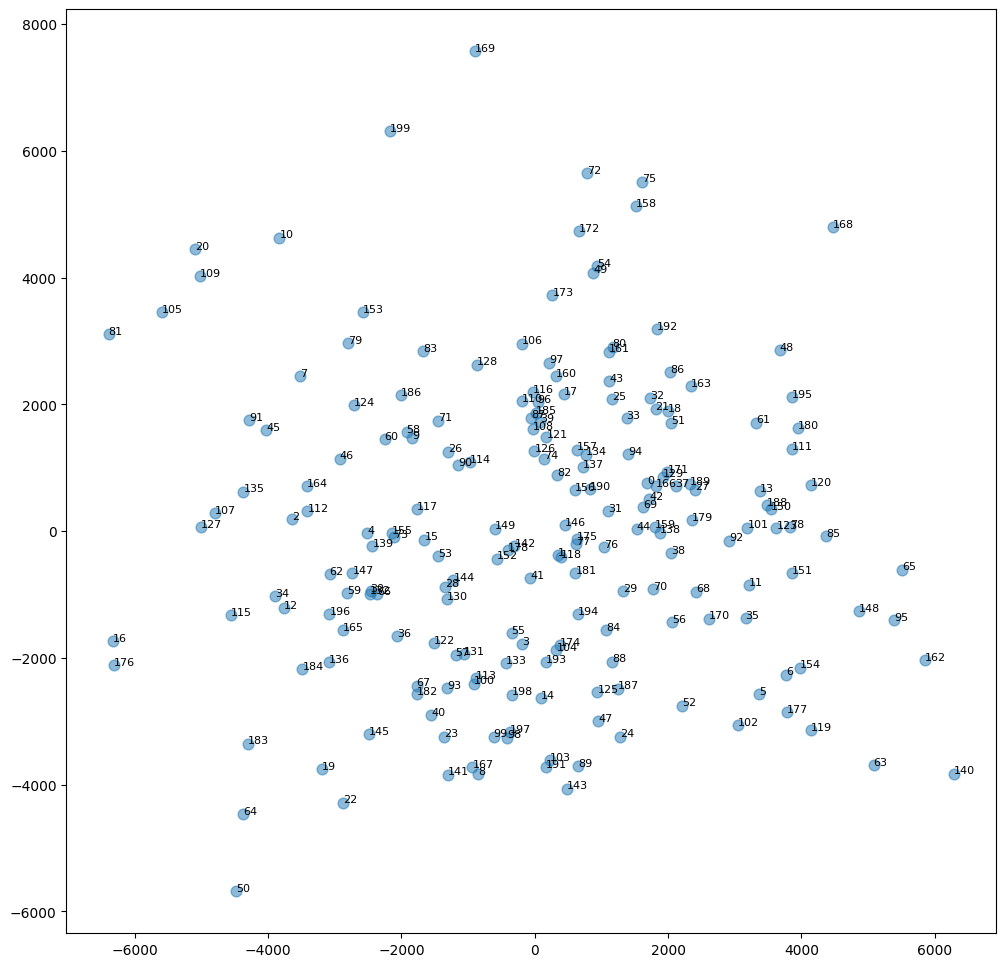

In [10]:
aux_funcs.plot_reduced_data(imgs_pca)

From the ploted graph we can now explore some patterns between images.<br>
Lets check similarities between the following images

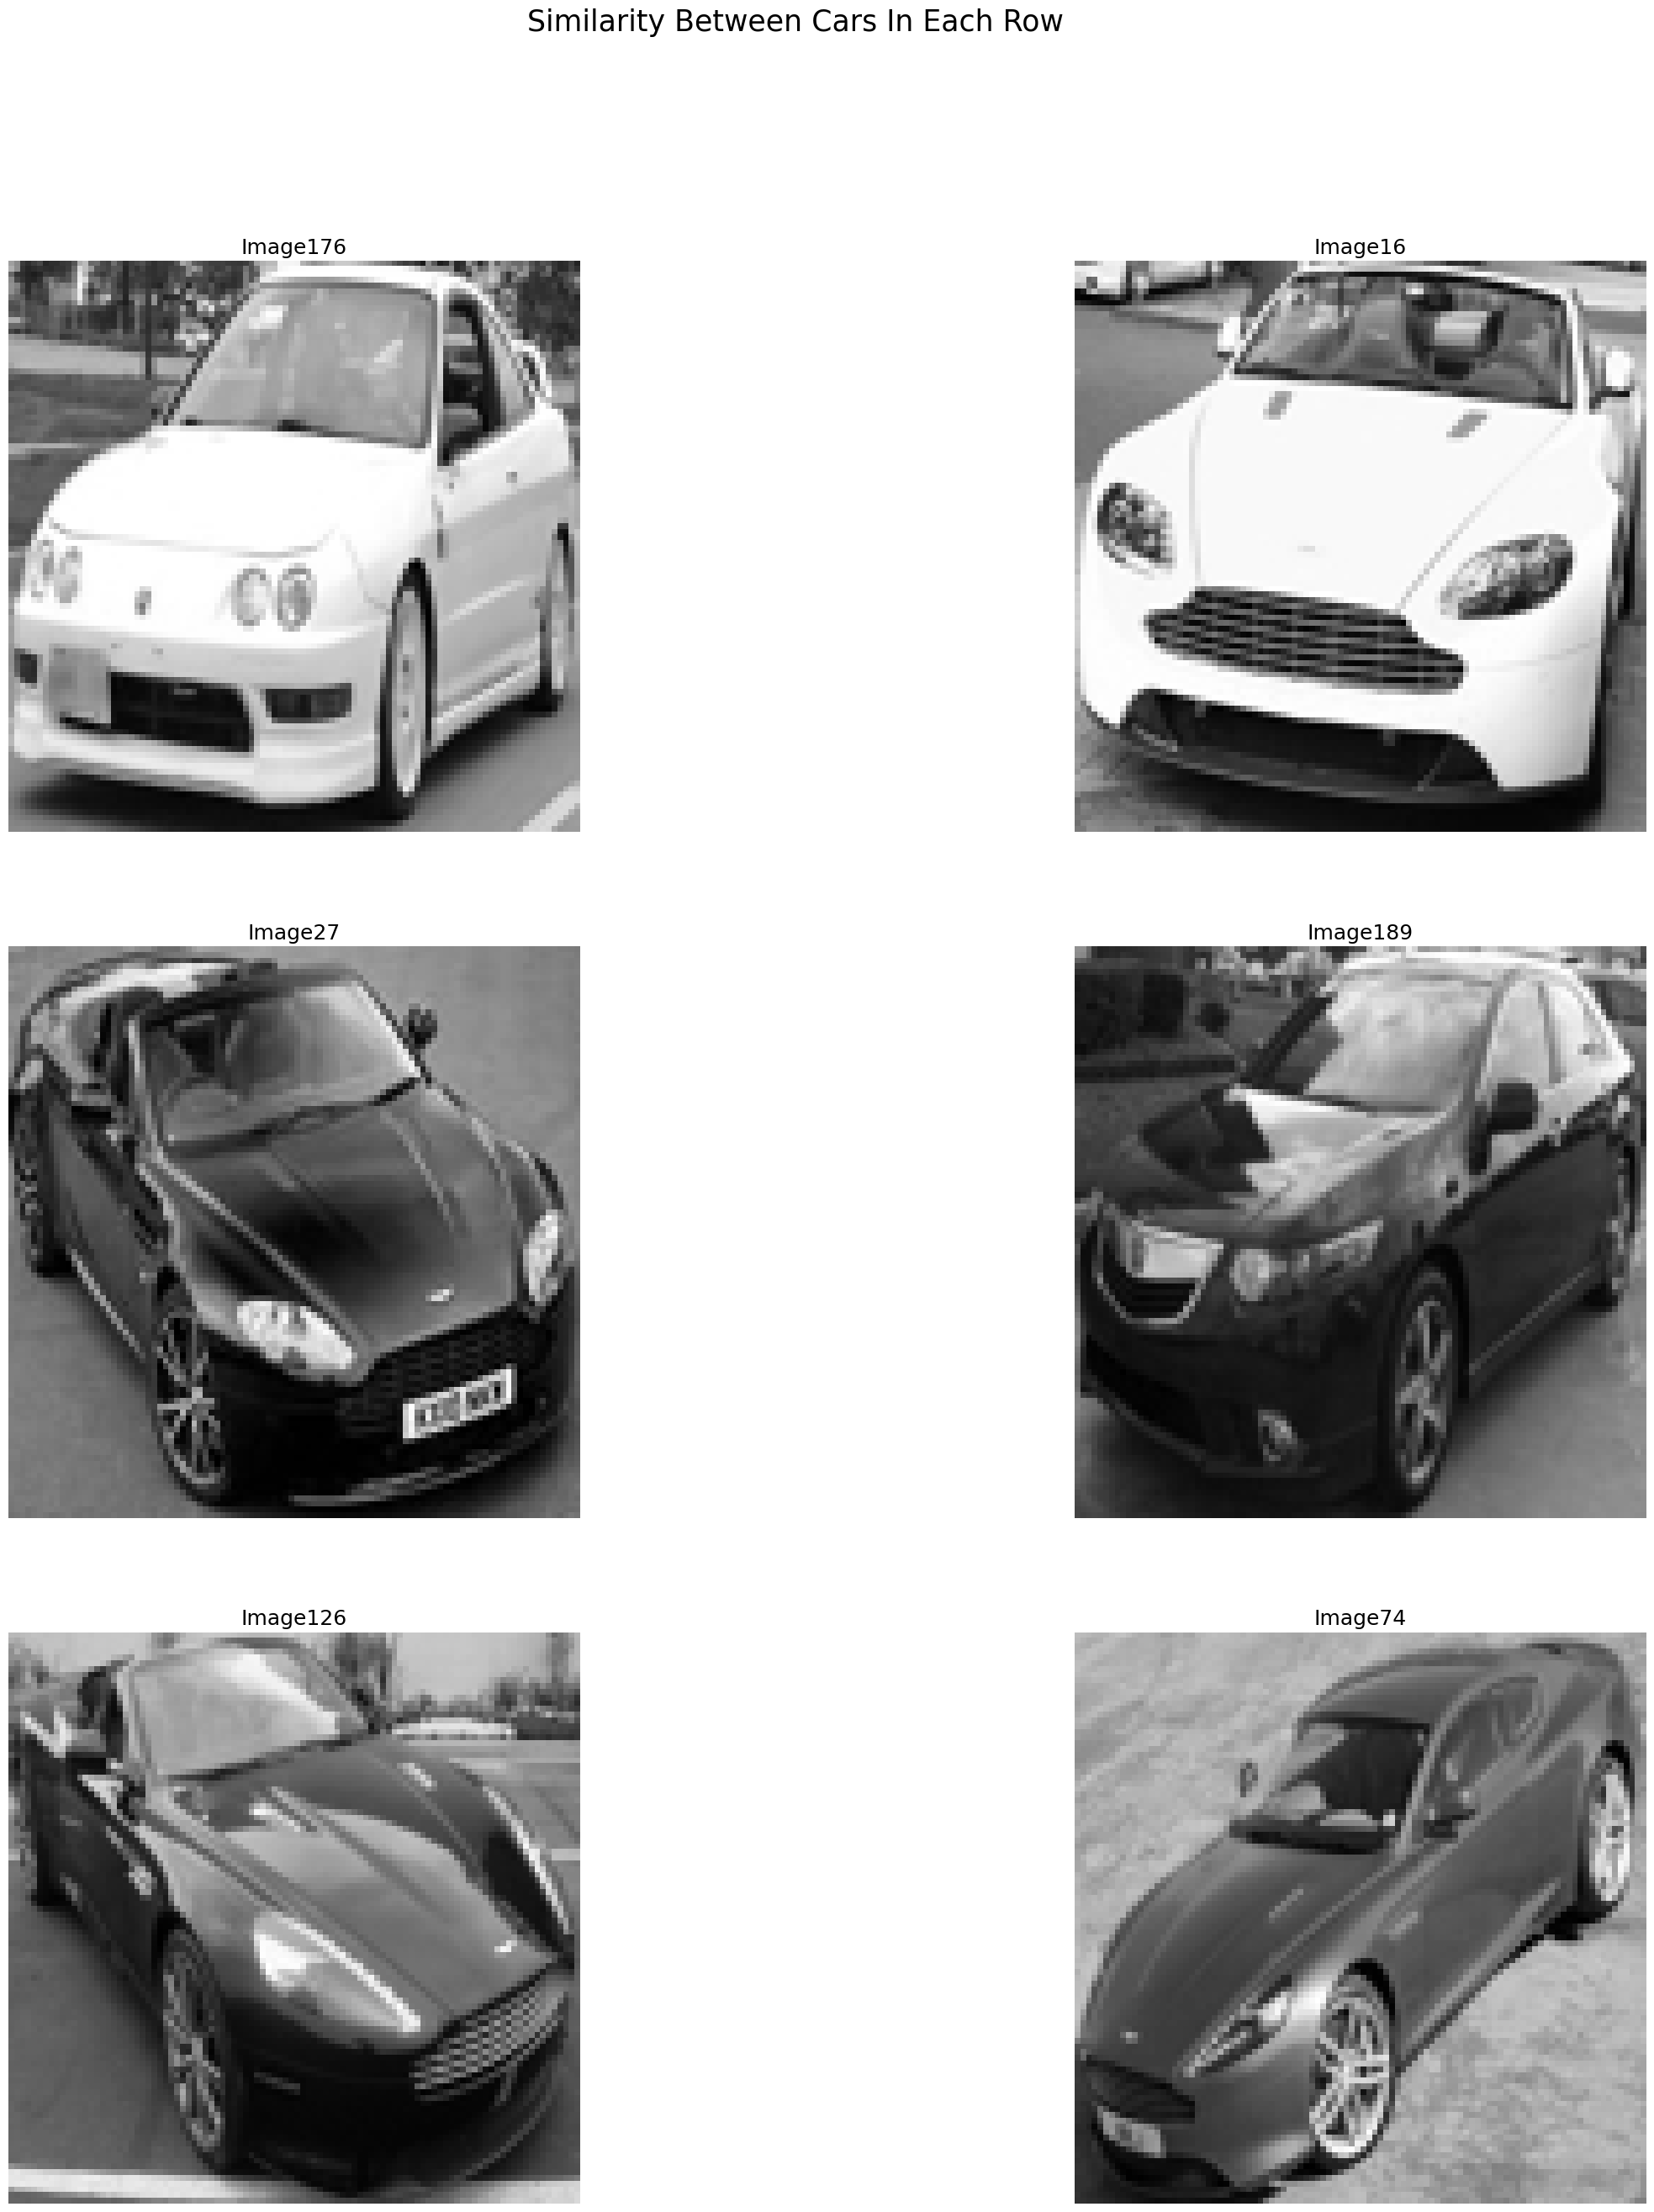

In [11]:
check_sim = [(176,16),(27,189),(126,74)]
_,ax = plt.subplots(3,2, figsize=(30,30))
for row,tup_img in enumerate(check_sim):
    for col,img_idx in enumerate(tup_img):
        ax[row,col].imshow(imgs[img_idx],cmap='grey')
        ax[row,col].set_title(f'Image{img_idx}',size=18)
        ax[row,col].axis('off')
plt.suptitle('Similarity Between Cars In Each Row',size=25)
plt.show()

For each row we can clearly see that for the first row both cars are white, for the second row both cars are black, and for the last row the two cars are the same. if any dismatches occurs that's fine. We only capture as much as possible from images information from just 2 components instade of 10000 component!<br>
So, if we increased the number of components we depend on in our data we will gain a much better information from data, But how to decide how many components to use for the dimensionality reduction? Here's explained variance comes in role! Let's see.

The explained variance of a principal component is the ratio between its associated eigenvalue and the sum of all the eigenvalues. $\frac{\lambda_1}{\sum_{i=1}^{100} \lambda_i}$

In [12]:
explained_variance_ratio = eigenvals/sum(eigenvals)
#Since we take the first 2 components with the highest eigenvalues
print(f'The First 2 Components Capture {int(sum(explained_variance_ratio[:2])*100)}% From Data')

The First 2 Components Capture 28% From Data


28% from our data will not be enough and we want to capture more information. But as we can see before, from the first 2 components only, we can catch similarities also from car images!<br>
Let's assume we want 95% from our data to be retrieved, Let's see how to decide number of components

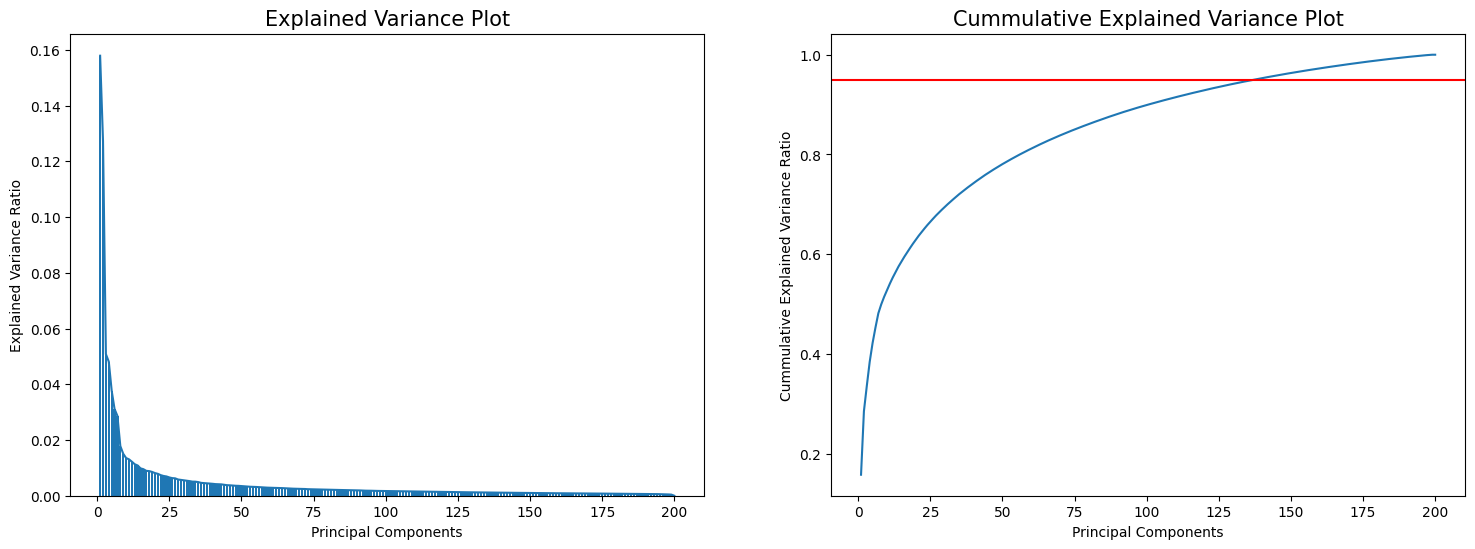

In [13]:
aux_funcs.visualize_exp_var(x_range=range(1,201), exp_var=explained_variance_ratio, axhline= 0.95)

We conclude that to obtain 95% from the data we need approximately 138 principal component

If we want to reconstruct image from the principal compnents, it simply making `200X2 2X10000` and return to the original matrix with the simple dot product of the two metrices! the result is `200X10000` matrix. Note that 2X10000, the 2 refers to the first 2 principal components and the 10000 refers to the number of rows of each eigenvect!

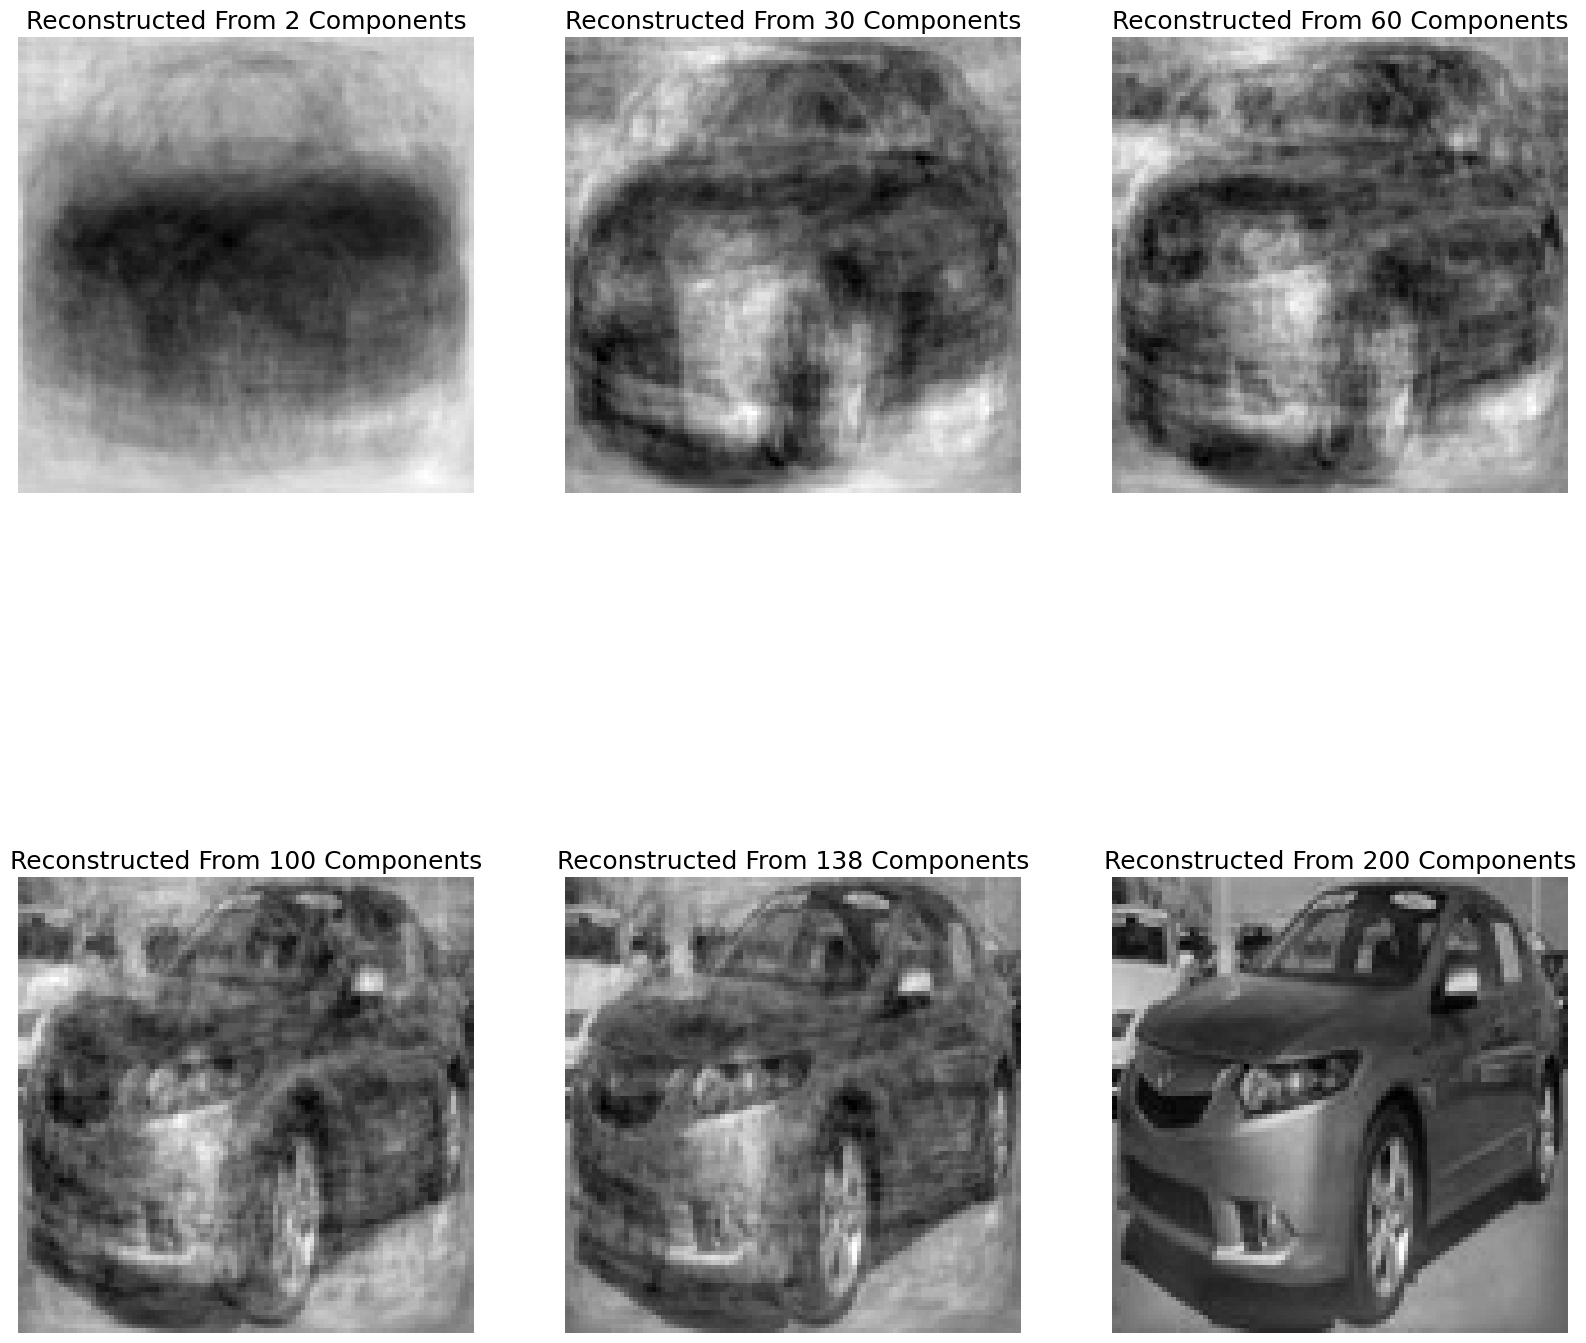

In [14]:
_,ax = plt.subplots(2,3, figsize=(20,20))
n_components = [(2,30,60),(100,138,200)]
for r,tup_comp in enumerate(n_components):
    for c,n in enumerate(tup_comp):
        construct = aux_funcs.perform_PCA(data_centered=imgs_flatten_centered,eigenvects=eigenvects,k=n)
        re_construct = aux_funcs.reconstruct_manually(imgs_pca=construct, eigenvects=eigenvects)
        ax[r,c].imshow(re_construct[0].reshape(100,100),cmap='grey') #[0] to select fixed image.
        ax[r,c].set_title(f'Reconstructed From {n} Components',size=18)
        ax[r,c].axis('off')

Now it's all clear! When we reconstruct the image from few number of components we get a disturted image since the returned information about the image can't capture the whole info about the image, But when we increase the number of components to depend on the image get's more clear and clear, such as the `138` components returned about 95% from the image, and considering the whole components `200` returns all of the information of the image as well!

# 2 : Applying PCA algorithm using sklearn

We will start from `imgs_flatten` while we have a 200 row (image) with 10000 columns
- Standardize (Scale) data 
- Apply PCA

In [15]:
scaler = StandardScaler()
imgs_flatten_centered_2 = scaler.fit_transform(imgs_flatten)
print(f'Data now has mu = {int(imgs_flatten_centered_2.mean())} and std = {int(np.sqrt(imgs_flatten_centered_2.var()))}')

Data now has mu = 0 and std = 1


We centered the data as the step we do before manually by subtracting the mean matrix from our flatten matrix and computing the centerized matrix! But now it's more easily using sklearn! but actually we now understand and know what is happening in the background!<br>
An additional step here that after the data is centerized we scale it by dividing each element by the std. and since the data is all scaled there is no effect on computing the PCA algorithm and we will prove that.<br>
**Note: For anyone trying this, you can make any scale you want like RobustScaling or MinMaxScaling, But visualize your images after putting it on any different scale and see the difference and decide be yourself which is better on your data! That's your task if you want.**

In [16]:
pca = PCA() #If we need 95% from our data apply PCA(0.95) and the output will be 138 as we did before!
#We expect a new data with shape (200 image,n components of our data '200')
imgs_const = pca.fit_transform(imgs_flatten_centered_2)
print(f'Our matrix shape reduced to {imgs_const.shape} with n_components {pca.n_components_}')

Our matrix shape reduced to (200, 200) with n_components 200


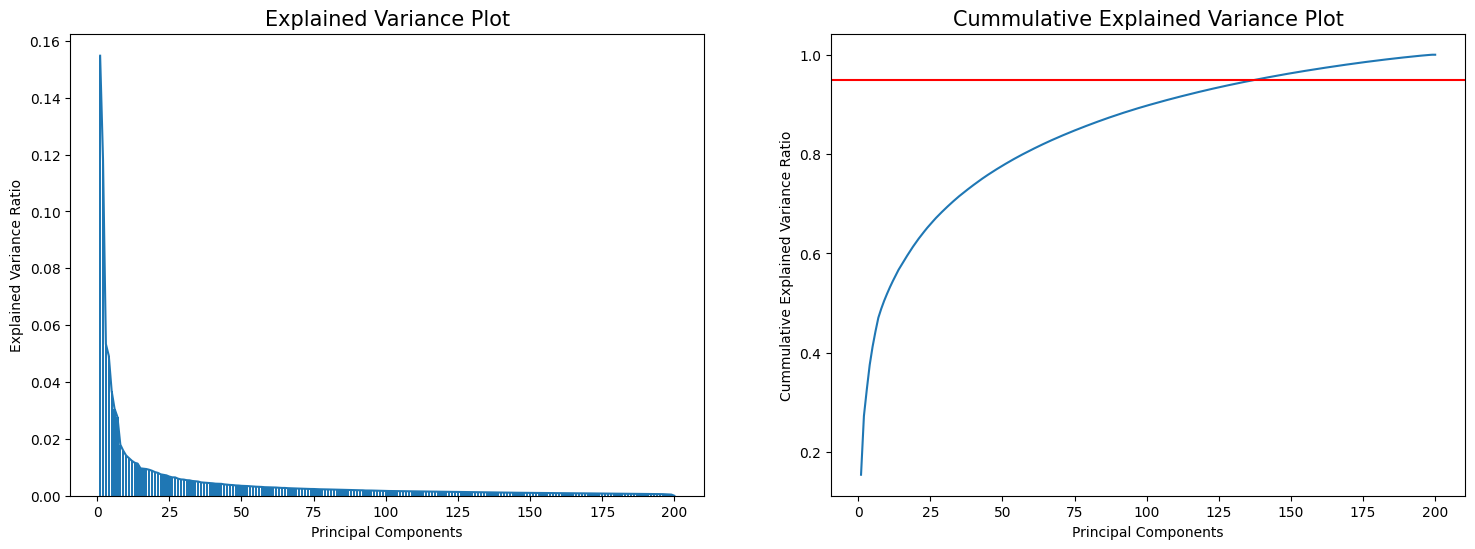

In [17]:
#Visualize Explanied variance (We will achieve the same thing:95% of data will be from 138 components from plot)
aux_funcs.visualize_exp_var(x_range=range(1,201),exp_var=pca.explained_variance_ratio_,axhline=0.95)

Can you see how we achieve the same thing with only 2 cells of code! But we get a full intuation about what is happening in the background.

In [18]:
#Verifying that 95% of the data achieved from the first 138 components
pca_2 = PCA(0.95)
imgs_const_2 = pca_2.fit_transform(imgs_flatten_centered_2)
print(f'Matrix shape reduced to {imgs_const_2.shape} with n_components {pca_2.n_components_}')
#If we want 2 principal components from the data we can achieve it by
pca_2 = PCA(n_components=2)
imgs_const_2 = pca_2.fit_transform(imgs_flatten_centered_2)
print(f'Matrix shape reduced to {imgs_const_2.shape} with n_components {pca_2.n_components_}')

Matrix shape reduced to (200, 138) with n_components 138
Matrix shape reduced to (200, 2) with n_components 2


Now we will try to reconstruct images as before but from the output of PCA using sklearn and see that the same process occurs<br>
**Note: PCA using sklearn offers the singular values NOT the eigen values so to obtain the eigen values from singular values we use the equation $\text{Eigenvalue} = \frac{\text{Singular value}^2}{n-1}$**

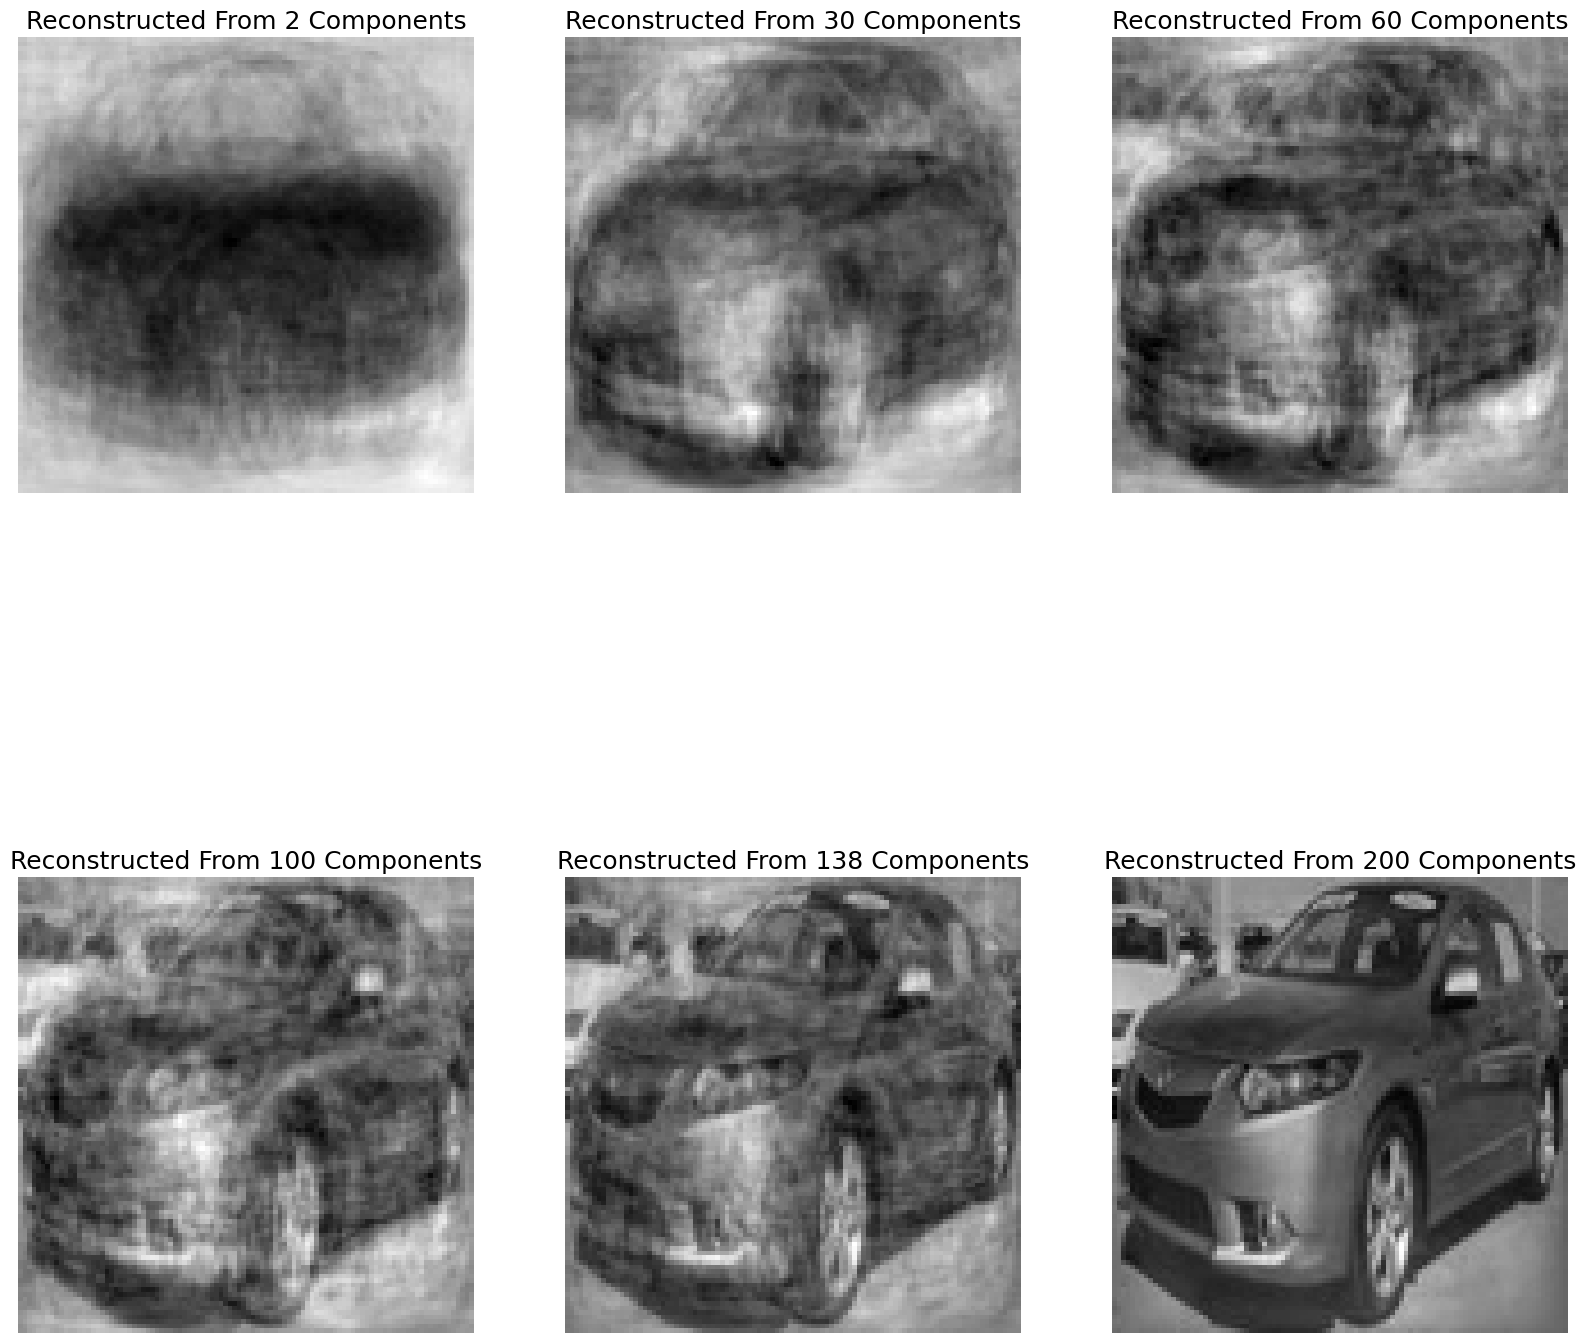

In [19]:
_,ax = plt.subplots(2,3, figsize=(20,20))
n_components = [(2,30,60),(100,138,200)]
for r,tup_comp in enumerate(n_components):
    for c,n in enumerate(tup_comp):
        pca_construct = PCA(n_components=n)
        construct = pca_construct.fit_transform(imgs_flatten_centered_2)
        sk_eigenvects = pca_construct.components_
        re_construct = aux_funcs.reconstruct_sk(imgs_pca=construct,eigenvects=sk_eigenvects,k=n)
        ax[r,c].imshow(re_construct[0].reshape(100,100),cmap='grey') #[0] to select fixed image.
        ax[r,c].set_title(f'Reconstructed From {n} Components',size=18)
        ax[r,c].axis('off')

Now we have a full overview of what is going on and how with fewer code we achieve our needs! But now we understand the background and the basics of the PCA algorithm!

## References :
- https://www.coursera.org/learn/machine-learning-linear-algebra
- https://media.licdn.com/dms/image/D4D12AQF61SUXClGqIg/article-cover_image-shrink_720_1280/0/1660108512262?e=1716422400&v=beta&t=10Fo2-oZJdVd9MRY1P_HeT8aymBAlTsKxbu8F38iwvg